<h1><center>Differentiable Hartree-Fock & the H$_2$-molecule </center></h1>
In this notebook, the application of quantum algorithms on the Hartree-Fock approximation for quantum chemistry systems will be discussed. As an explicit example, properties of H$_2$ are calculated with PennyLane.

# 1 Theory
The concept of the Hartee-Fock approximation for many particle systems will briefly be discussed. Atomic and CGS units will be used, i.e. $\hbar=e_0=m_e=4\pi\epsilon_0=1.$

## 1.1 Quantum Chemistry

The physical properties of systems investigated in quantum chemistry (e.g. molecule bindings, electrolyte-surface interfaces, ...) are derived from the many body state $|\psi \rangle$, which solves the stationary Schrödinger equation

$$ \hat{H}|\psi \rangle=E |\psi \rangle. $$

In the following, the occupation number representation will be used, i.e.

$$ |\psi \rangle \rightarrow |n_1,n_2,...,n_N \rangle, $$

with fermionic occupation numbers $n_i =0,1$ of particle $i$. Further, we will assume a non degenerate ground state  and thermodynamic equilibrium at $T=0$K.<br> <br>
Methods in many particle theory like Hartree-Fock, which is used in the quantum chemistry methods of PennyLane, can smartly be formulated in second quantization, introducing the fermionic ladder operators.
The molecular Hamilton operator in second quantization can be derived as

$$ \hat{H} = \sum_{p,q}h_{p,q}\,a_p\,a^{\dagger}_q \, +\, \frac{1}{2}\sum_{p,q,r,s}h_{p,q,r,s}\,a^{\dagger}_p\,a^{\dagger}_q a_r \,a_s\,, $$

with $a^{\dagger}_q$, $a_q$, $a^{\dagger}_p$, ... being the fermionic ladder operators that act on particle $q,p,r,s$ respectively:

$$ \begin{align*}
a^{\dagger}_i|n_1,n_2,...,n_i,...\rangle & = \sqrt{n_i+1}\,|n_1,n_2,...,n_i+1,...\rangle,\\ 
 a_i|n_1,n_2,...,n_i,...\rangle & = \sqrt{n_i}\,|n_1,n_2,...,n_i-1,...\rangle . \end{align*}$$

The coefficients $h_{p,q}$ and $h_{p,q,r,s}$ in terms of single particle orbitals $\Phi(\mathbf{r})$ can be written as

$$ h_{p,q}= \int \mathrm{d}^3\mathbf{r}\,\Phi^{\star}_p(\mathbf{r})\left[ -\frac{\nabla^2}{2}- \sum_{i=1}^{N_\mathrm{cores}} \frac{Z_i}{|\mathbf{r}-\mathbf{R_i}|}\right] \Phi_q(\mathbf{r}) ,$$

denoting the $p\rightarrow q$-matrix element of the kinetic energy + the single particle coulomb interaction with the core $i$ with atomic number $Z_i$ and coordinate $\mathbf{R_i},$ and

$$ h_{p,q,r,s} = \int \mathrm{d}^3\mathbf{r_1}\int \mathrm{d}^3\mathbf{r_2} \frac{\Phi^{\star}_p(\mathbf{r_1})\Phi_s(\mathbf{r_1})\Phi^{\star}_q(\mathbf{r_2})\Phi_r(\mathbf{r_2})}{|\mathbf{r_1}-\mathbf{r_2}|}$$

beeing the two electron pair interaction energy at locations $\mathbf{r_1}$ and $\mathbf{r_2}$.

With this full (i.e. exact) Hamiltonian, the Schrödinger equation for real systems cannot be solved for more than two particles. The problem lies in the correlation terms in the electronic interaction energy.<br>
There's a lot of first principle methods in theoretical and computational physics to describe such systems using approximations.<br>
A popular method that simply neglects the electronic correlation is the Hartree-Fock approximation, which will be discussed in the following chapter.


## 1.2 Hartree-Fock
The central approximation in the Hartree-Fock method is the mean field approximation for the electron-electron interaction. The exact interaction term $h_{p,q,r,s}$ is replaced with an artificial (non physical) field of non interacting electrons in which every electron interacts with this artificial field individually. With this, the electron correlation is removed, which also means that the Hartree-Fock method is in principal not exact. Thus, even with infinite numerical precision, no observables can be measured exactly. <br>
The consequence of the introduction of the non interacting system is that the Hamiltonian now becomes seperable, and we only have to solve one-particle eigenvalue problems. The one-particle orbitals arising from these one-particle Schrödinger equations create the mean field. But because the mean field depends on the one-particle orbitals, these equations must be solved self consistently, which is displayed in the following figure (taken from  [[1]](#another_cell)):


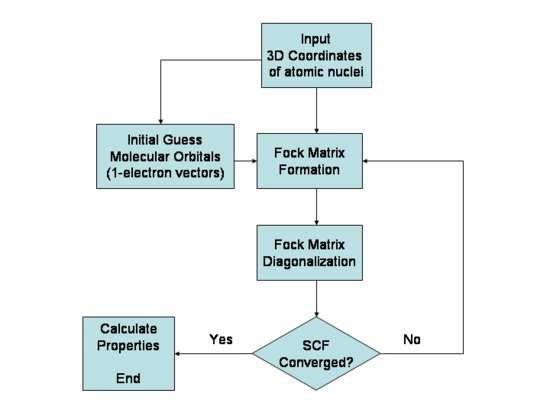
After choosing initial conditions (nuclei positions and initial guess for the electronic orbitals), a self-consistent-field (scf) cycle will be deployed to achieve electronic relaxation:
* construct the Hartee-Fock-operator (which contains the mean field)
* solve the eigenvalue problems for the one particle orbitals
* update the mean field, which updates the Hartee-Fock-operators
* solve the eigenvalue problems
* repeat until proper self consistent convergence is achieved. <br>

This scf algorithm is used in the classical HF algorithm, as well in the quantum algorithm used by PennyLane, as can be seen in the source code.

# 2 Implementation
The simulations will be done using **PennyLane** and Python3.9. The code is taken from
[[2]](#another_cell) and [[3]](#another_cell).<br> 
PennyLane simulates a quantum computers hardware, so that quantum algorithms can be run. Predefined methods that realize the Hartree-Fock formalism with quantum algorithms are given. 

## 2.1 Self consistent field
Firstly, we want to examine how the self consistent iteration of the electronic relaxation works. In PennyLane, this is done via the `scf()` method. <br>
A atomic arrangement is defined via the `Molecule` method, that takes arguments `symbols` (atomic species) and `geometry` (nuclear coordinates). Atomic numbers until $Z=10$ are supported. For the investigation of the scf algorithm, we will use two N (Nitrogen) atoms with a spacing of 0.2 Bohr in the $x$-direction:

In [1]:
from autograd import grad
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=5)

symbols = ["N", "N"] # definition of atom species
geometry = np.array([[0.1, 0.0, 0.0],                         # definition of the atom spacing, 
                     [ -0.1, 0.0, 0.0]], requires_grad=True)  # i.e nuclear coordinates

mol = qml.qchem.Molecule(symbols, geometry)

`scf()` takes the argument `mol`, which is the definition via `Molecule` and two parameters which control the scf sequence, `n_steps` and `tol`. They manage the maximum number of iteration steps of the cycle and the convergence threshhold of the parameters of the single particle orbitals.<br>
`scf()` returns the values `eigvals, coeffs, fock_matrix, h_core, rep_tensor`. Let's evaluate the eigenvalues of the one particle orbiats `eigvals`. Since Nitrogen has 5 valence electrons and since we have put two Nitrogen atoms, we expect to have an output of 2 $\times$ 5 eigenvalues, each corresponding to a single particle orbital:

In [2]:
out = qml.qchem.scf(mol)(geometry)
print(out[0])

[-38.59101 -10.7816   -2.89985  -1.94734  -1.93461  -0.48891   0.60433
   0.98481   1.19985   9.37332]


To investigate the convergence in the scf algorithm, we can pick one of the eigenvalues and observe its convergence, which qualitatively shows the convergence of the corresponding orbital:

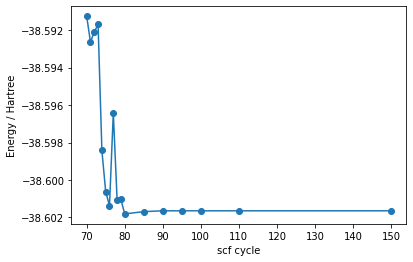

In [3]:
es = [] # energy eigenvalues
ns = [70,71,72,73,74,75,76,77,78,79,80,85,90,95,100,110,150] # max scf cycles
for i in ns:
    out = qml.qchem.scf(mol,n_steps=int(i),tol=1e-30)(geometry)
    es.append(out[0][0])

plt.plot(ns,es,marker="o")
plt.xlabel("scf cycle")
plt.ylabel("Energy / Hartree")
plt.show()

We can see that the energy eigenvalue converges at  `n_steps` $\approx$ 80. This investigation of the convergence can in principle be done as well with the coefficients of the wavefunction expansion (`coeffs`).

## 2.2 Classical Variation
We now turn to the investigation of the H$_2$-molecule. The central quantity, we will use to investigate its properties, is the total quantum mechanical energy. The total energy in Hartree-Fock approximation is calculated via `hf_energy(mol)(geometry)`:

In [1]:
symbols = ["H", "H"]
# optimized geometry at the Hartree-Fock level
geometry = np.array([[-0.672943967415407, 0.0, 0.0],
                     [ 0.672943967415407, 0.0, 0.0]], requires_grad=True)
mol = qml.qchem.Molecule(symbols, geometry)
a = qml.qchem.hf_energy(mol)(geometry)
print(a)

[-1.11751]


With these predefined methods, we can compute e.g. the bonding length of the H$_2$ molecule by minimizing the total energy $E=\langle\psi(\mathbf{R})|\hat{H} |\psi(\mathbf{R})\rangle$ in terms of the molecular coordinates $\mathbf{R}$:

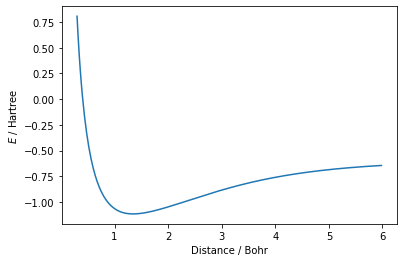

Bonding length = 1.34 Bohr


In [28]:
x=[]
y=[]

for i in range(15,300):
    b = i/100
    geometry = np.array([[b, 0.0, 0.0],
                         [ -1*b, 0.0, 0.0]], requires_grad=True)

    mol = qml.qchem.Molecule(symbols, geometry)
    energy=qml.qchem.hf_energy(mol)(geometry)
    x.append(2*b)
    y.append(energy)

    plt.plot(x,y)
plt.ylabel("$E$ / Hartree")
plt.xlabel("Distance / Bohr")
plt.show()
min=np.argmin(y)
print("Bonding length =",x[min],"Bohr") # approximate bonding length of H_2 in Bohr

This achieves $\approx$ 4% deviation from numerical results using DFT (ref. [[4]](#another_cell)).<br><br>
We see the expected behaviour of the total energy, having a global minimum at some point (the equilibrium distance), diverging for small distances due to the Coulomb repulsion and converging to some energy value for large distances (which cannot be zero due to the energy contributions of the atoms themselfs).<br> <br>
With the same principle, the gradient $\nabla E$ in terms of the nuclear coordinates can be displayed via the
`grad()` method. Since in the above example we only varied the nuclear coordinates in the $x$-direction, we compute the gradient only in $\mathbf{R_x}$-direction as well:

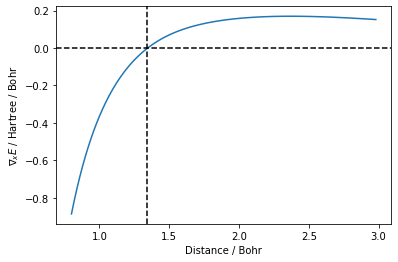

In [39]:
x=[]
y=[]

for i in range(40,150):
    b = i/100
    geometry = np.array([[b, 0.0, 0.0],
                         [ -1*b, 0.0, 0.0]], requires_grad=True)

    mol = qml.qchem.Molecule(symbols, geometry)
    d_energy=grad(qml.qchem.hf_energy(mol))(geometry)
    x.append(2*b)
    y.append(d_energy[0][0])  
plt.plot(x,y)
plt.axhline(y=0,linestyle="--",color="black")
plt.axvline(x=1.34,linestyle="--",color="black")
plt.ylabel(r"$\nabla_xE$ / Hartree / Bohr")
plt.xlabel("Distance / Bohr")
plt.show()

Unsurprisingly, the gradient reaches zero at the prior computed bonding length, as change in energy should be minimal in the region of the equilibrium distance.

#  3 Conclusions

We have investigated a simple system in the Hartree-Fock picture using quantum algorithms. We have produces reasonable results, such as the bonding length of $H_2$. The value we received is comparable to what we get from state of the art methods that use classical algorithms. <br>
A further investigation of the program runtime using comparable convergence parameteres for the PennyLane and some classical algorithm would be very useful, to see if and how the quantum algorithm based methods improve the performance. 


<a id='another_cell'></a> 
# References 

[1] *Hartree-Fock method*, Wikipedia, https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method<br>
[2] *Differentiable quantum computational chemistry with
PennyLane*, Juan Miguel Arrazola et al., https://arxiv.org/abs/2111.09967
<br>
    [3] *Differentiable Hartree-Fock*, Website, Soran Jahangiri, https://pennylane.ai/qml/demos/tutorial_differentiable_HF.html <br>
                                                                                                                                    [4] *Describing static correlation in bond dissociation by Kohn–Sham density functional theory*, Martin Fuchs et al, The Journal of chemical physics 122, page 94116